In [8]:
import sys
import os
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn import datasets


from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score ,learning_curve ,GridSearchCV


from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import alibi.explainers as ale
import lime
import lime.lime_tabular
import shap




import warnings
warnings.filterwarnings('ignore')

In [9]:
# fonctions dans le fichier py 
from utils import display_original_pdp_values, detect_variable_types, winsorize_data, display_original_pdp_values

In [10]:
os.getcwd()

# chemin pour le fichier py avec les foncitons
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
#dossier  path
data_path = Path.cwd().parent / "data"

# récupereation des données 
df = pd.read_csv( data_path / "df_clean.csv")
print(df.shape)

(44552, 25)


In [11]:
df = df.drop(columns=['height(cm)'])

types = detect_variable_types(df)

num_cols = types["numerical"]
bool_cols = types["boolean"]
ordinal_col = ['Urine_protein']

num_cols.remove("Urine_protein")
bool_cols.remove("smoking")

columns_to_winsorize = [
    'ALT', 'AST', 'Gtp', 'serum_creatinine',
    'LDL', 'HDL', 'triglyceride', 'Cholesterol',
    'fasting_blood_sugar', 'systolic', 'relaxation', 'hemoglobin'
]


# I. Interpréter globale du meilleur modèle 

On relance le modele que nous avons choisi dans la partie 02_modeles

In [12]:
# Repartir proprement
X = df[num_cols + bool_cols + ordinal_col].copy()
y = df["smoking"].copy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Winsorisation
for col in columns_to_winsorize:
    X_train[col], X_test[col] = winsorize_data(X_train, X_test, feature=col)

# Préprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('ord', OrdinalEncoder(), ordinal_col),
    ('bool', 'passthrough', bool_cols)
])


In [13]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ))
])

pipeline.fit(X_resampled, y_resampled)

# 2. Prédictions sur X_test
y_pred = pipeline.predict(X_test)

# 3. Évaluation
print("Résultats Gradient Boosting - Undersampling seul :")
print("Recall     :", recall_score(y_test, y_pred))
print("F1-score   :", f1_score(y_test, y_pred))
print("Accuracy   :", accuracy_score(y_test, y_pred))
print("Precision  :", precision_score(y_test, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))


# Pour l’interprétabilité :  modèle et les données transformées
model = pipeline.named_steps['model']
X_test_prepared = pipeline.named_steps['preprocessing'].transform(X_test)
feature_names = num_cols + ordinal_col + bool_cols

Résultats Gradient Boosting - Undersampling seul :
Recall     : 0.8918836140888208
F1-score   : 0.7201681711388649
Accuracy   : 0.7460442150151498
Precision  : 0.6038987971795935
Matrice de confusion :
 [[3736 1910]
 [ 353 2912]]


On vérifie que le modèle réalise correctement une prédiction pour un individu

# Différentes méthodes d'interprétations de modèle 

## 1. Importance des variables - GradientBoostingClassifier (modèle non linéaire)

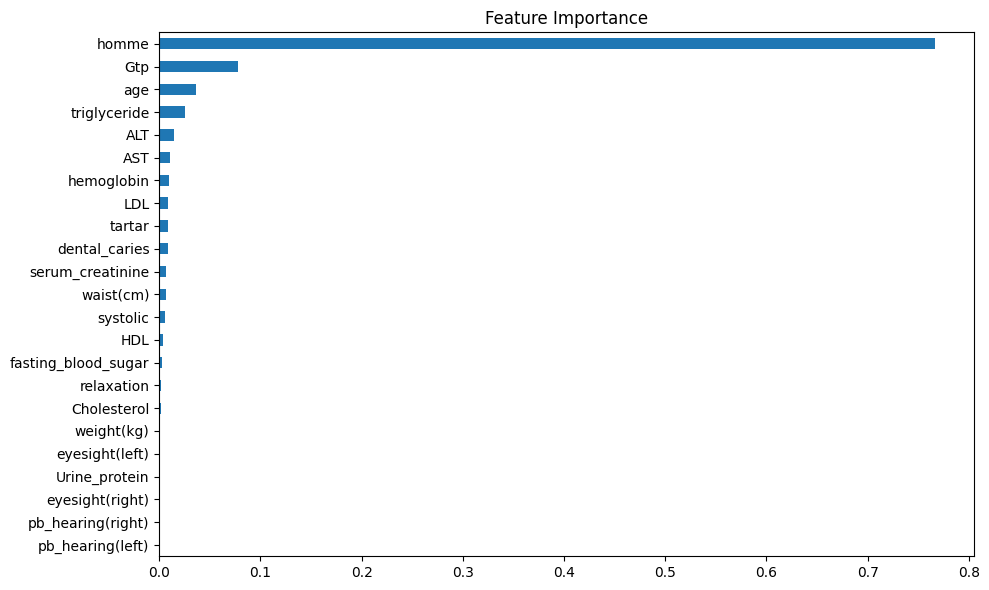

In [14]:
importances = pd.Series(model.feature_importances_, index=feature_names)
importances.sort_values(ascending=True).plot(kind="barh", figsize=(10, 6), title="Feature Importance")
plt.tight_layout()
plt.show()


In [16]:
importances.sort_values()

pb_hearing(left)       0.000000
pb_hearing(right)      0.000090
eyesight(right)        0.000283
Urine_protein          0.000395
eyesight(left)         0.000817
weight(kg)             0.000984
Cholesterol            0.001793
relaxation             0.002191
fasting_blood_sugar    0.003036
HDL                    0.003628
systolic               0.005623
waist(cm)              0.006834
serum_creatinine       0.006945
dental_caries          0.008365
tartar                 0.008811
LDL                    0.008919
hemoglobin             0.009319
AST                    0.010382
ALT                    0.015086
triglyceride           0.025643
age                    0.036633
Gtp                    0.077739
homme                  0.766484
dtype: float64

## 2. PDP 

**Variables quantitaves**

PDP (Partial Dependence Plot)
Le PDP (Graphique de dépendance partielle) montre comment une variable influence la prédiction en moyenne, en maintenant les autres constantes.

on veut voir comment le modèle généralise sur de nouvelles données, donc on utilisera X_test

Montre l'effet moyen d'une variable sur la prédiction

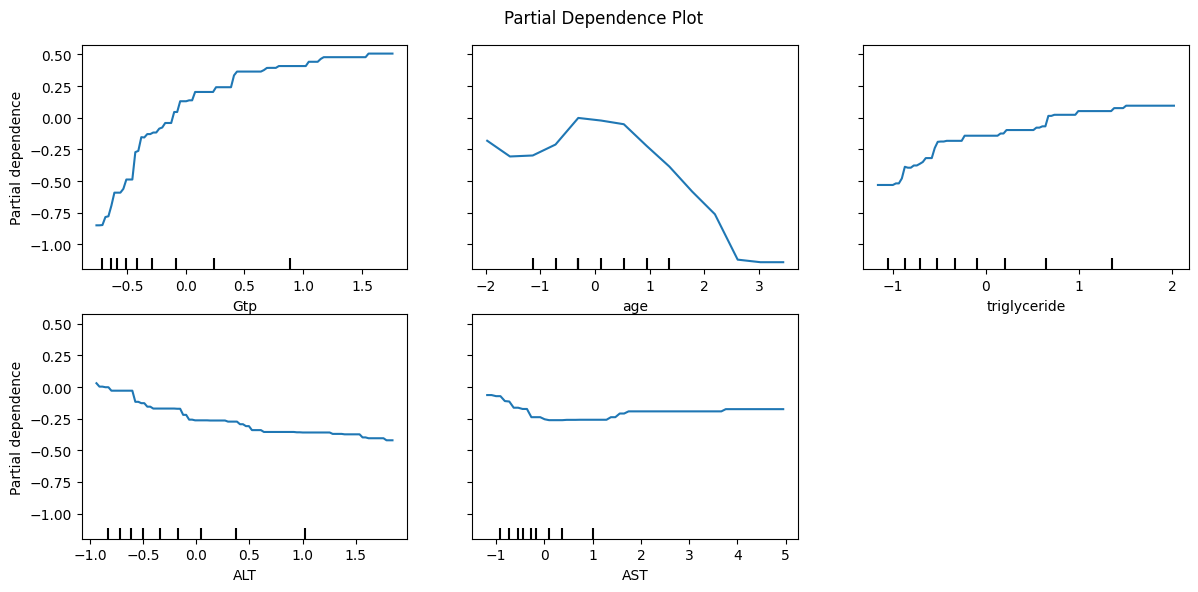

In [17]:
features = ["Gtp", "age" , "triglyceride", "ALT", "AST"] # premiers 5 variables 

_, ax1 = plt.subplots(figsize = (12,6))

PartialDependenceDisplay.from_estimator(
    model,
    X_test_prepared,
    features=features,  
    feature_names=feature_names,
    kind="average",
    grid_resolution=100,
     ax = ax1
)
plt.suptitle("Partial Dependence Plot")
plt.tight_layout()
plt.show()

un pipeline avec standardisation, ce qui a un impact sur l’interprétation directe des Partial Dependence Plots (PDP)

À mesure que la valeur de "Gtp" augmente (de gauche à droite), la dépendance partielle augmente également, surtout entre environ -0.5 et 0.5. Cela suggère que des valeurs plus élevées de Gtp tendent à augmenter la probabilité que le modèle prédise la classe positive. L'effet semble se stabiliser pour les valeurs de Gtp supérieures à environ 1.0

In [18]:
feature_names

['age',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'systolic',
 'relaxation',
 'fasting_blood_sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'serum_creatinine',
 'AST',
 'ALT',
 'Gtp',
 'Urine_protein',
 'dental_caries',
 'tartar',
 'homme',
 'pb_hearing(left)',
 'pb_hearing(right)']

In [19]:
num_cols.index("age")

0

In [23]:

# Nom de la variable à afficher
var_name = "age"

# 1. Récupérer l’index de la variable dans les features numériques
index = num_cols.index("age")

# 2. Transformer X_test brut avec le scaler uniquement
X_test_scaled = scaler.transform(X_test[num_cols])

# 3. Appeler la fonction
display_original_pdp_values(index, model, pd.DataFrame(X_test_scaled, columns=num_cols), scaler)


NameError: name 'scaler' is not defined

**Variables categorielles**

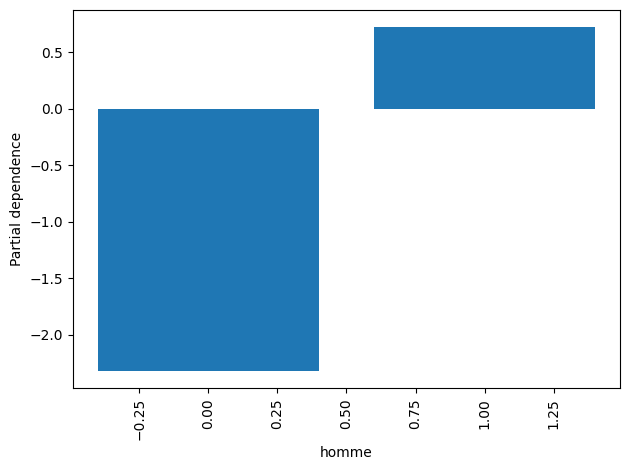

In [58]:
# Pour les noms complets dans l’ordre du préprocessing
feature_names = num_cols + ordinal_col + bool_cols

# Exemples pour PDP
categorical_vars = ["homme"]
categorical_indices = [feature_names.index(var) for var in categorical_vars]

PartialDependenceDisplay.from_estimator(
    model,
    X_test_prepared,
    features=categorical_indices,
    categorical_features=categorical_indices,
    feature_names=feature_names,
    kind="average"
)
plt.tight_layout()
plt.show()

## 3. Permutation Feature Importance

In [ ]:
random_permutation = permutation_importance(model, X, y,

                                    n_repeats=30,

                                    random_state=0)

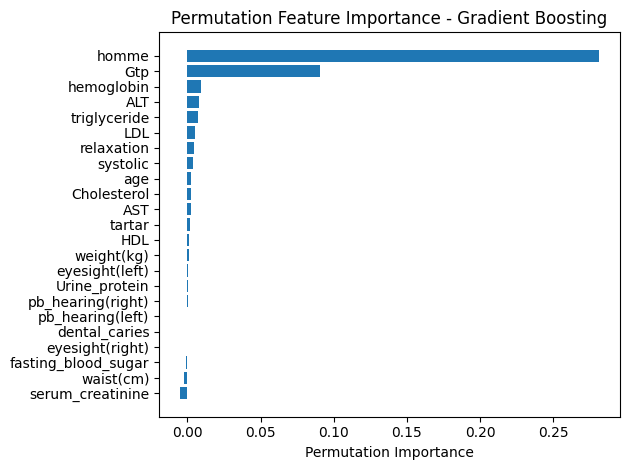

In [33]:

result = permutation_importance(
    model, X_test_prepared, y_test,
    scoring='recall', n_repeats=20, random_state=0, n_jobs=-1
)

perm_sorted_idx = result.importances_mean.argsort()
plt.barh(np.array(feature_names)[perm_sorted_idx], result.importances_mean[perm_sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance - Gradient Boosting")
plt.tight_layout()
plt.show()

## 4. SHAP (explication locale)

In [ ]:

# Init explainer
explainer = shap.Explainer(model.predict, X_test_prepared)
shap_values = explainer(X_test_prepared)

# Visualisation globale
shap.plots.beeswarm(shap_values, feature_names=feature_names)

# Visualisation locale (exemple 0)
shap.plots.waterfall(shap_values[0], max_display=10)


PermutationExplainer explainer:  18%|█▊        | 1575/8911 [00:53<04:22, 27.95it/s]